In [ ]:
! pip install aimodelshare --upgrade

In [ ]:
#load data
from zipfile import ZipFile
with ZipFile("world_happiness_competition_data.zip",'r') as zObject:
  zObject.extractall()
import pandas as pd
X_train = pd.read_csv('world_happiness_competition_data/X_train.csv')
X_test = pd.read_csv('world_happiness_competition_data/X_test.csv')
y_train = pd.read_csv('world_happiness_competition_data/y_train.csv')
y_train_labels = y_train.idxmax(axis=1)
X_train.head()

In [ ]:
#Preprocess data using Sklearn Column Transformer/ Write and Save Preprocessor function
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_features = X_train.drop(['Country or region', 'name', 'region', 'sub-region'], axis=1)
numeric_features=numeric_features.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region', 'sub-region']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

preprocess=preprocessor.fit(X_train)

def preprocessor(data):
    data.drop(['Country or region', 'name'], axis=1)
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data

preprocessor(X_train).shape

(88, 26)

In [ ]:
# model 1
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=5)
model.fit(preprocessor(X_train), y_train_labels)
model.score(preprocessor(X_train), y_train_labels)

0.9318181818181818

In [ ]:
! pip install aimodelshare --upgrade

In [ ]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

In [ ]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

# Check how many preprocessed input features are there?
from skl2onnx.common.data_types import FloatTensorType

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  #Insert correct number of preprocessed features

onnx_model = model_to_onnx(model, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())


In [ ]:
#Set credentials using modelshare.org username/password

from aimodelshare.aws import set_credentials

#This is the unique rest api that powers this World Happiness Classification Playground -- make sure to update the apiurl for new competition deployments
apiurl="https://e2w6gh3id1.execute-api.us-east-2.amazonaws.com/prod/m"

set_credentials(apiurl=apiurl)

In [ ]:
#Instantiate Competition
import aimodelshare as ai
mycompetition= ai.Competition(apiurl)

In [ ]:
#Submit Model 1: 

#-- Generate predicted values (Model 1)
prediction_labels = model.predict(preprocessor(X_test))

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                                  custom_metadata={"team":"2"}) 

Insert search tags to help users find your model (optional): R
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 570

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [ ]:
# Get leaderboard to explore current best model architectures

# Get raw data in pandas data frame
data = mycompetition.get_leaderboard()

# Stylize leaderboard data
mycompetition.stylize_leaderboard(data)

In [ ]:
#tune rfc
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(preprocessor(X_train),y_train_labels)


In [ ]:
best_rf.score(preprocessor(X_train),y_train_labels)

1.0

In [ ]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  # Insert correct number of preprocessed features

onnx_model = model_to_onnx(best_rf, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Submit tuned rfc: 

#-- Generate predicted values (Model 1)
prediction_labels = best_rf.predict(preprocessor(X_test))

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model2.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                                  custom_metadata={"team":"2"}) 


In [ ]:
#GB model
from sklearn.ensemble import GradientBoostingClassifier

test_GB = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1,
    max_depth=5, random_state=0,subsample=0.5).fit(preprocessor(X_train), y_train_labels)
test_GB.score(preprocessor(X_train), y_train_labels)

1.0

In [ ]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  # Insert correct number of preprocessed features

onnx_model = model_to_onnx(test_GB, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model3.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#submit model 3
prediciton_labels = test_GB.predict(preprocessor(X_test))

mycompetition.submit_model(model_filepath = "model3.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                                  custom_metadata={"team":"2"})

Insert search tags to help users find your model (optional): GGGGG
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 591

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [ ]:
#tune GB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
# creating a dict of grids
grid = dict()
# values for iteration
grid['n_estimators'] = [10, 50, 100, 500]
# values for learning rate
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# values for the sampel
grid['subsample'] = [0.5, 0.7, 1.0]
# values for teh depth of tree
grid['max_depth'] = [3, 4, 5]
# defining the cv
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
# applying the gridsearchcv method
grid_search = GridSearchCV(estimator=test_GB, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# storing the values
grid_result = grid_search.fit(preprocessor(X_train), y_train_labels)
# printing the best parameters of Gradient boosting algorithm using Python
print("Accuracy score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Accuracy score: 0.656481 using {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.5}


In [ ]:
#tuned GB
tuned_GB = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1,
    max_depth=5, random_state=0,subsample=0.5).fit(preprocessor(X_train), y_train_labels)
tuned_GB.score(preprocessor(X_train), y_train_labels)

1.0

In [ ]:
#submit tunedGB
from aimodelshare.aimsonnx import model_to_onnx

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  # Insert correct number of preprocessed features

onnx_model = model_to_onnx(tuned_GB, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model4.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

prediciton_labels = tuned_GB.predict(preprocessor(X_test))

mycompetition.submit_model(model_filepath = "model4.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                                  custom_metadata={"team":"2"})

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 621

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [ ]:
# deep learning model
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
feature_count=preprocessor(X_train).shape[1] #count features in input data
keras_model = Sequential()
keras_model.add(Dense(128, input_dim=feature_count, activation='relu'))
keras_model.add(Dense(64, activation='relu'))
keras_model.add(Dense(64, activation='relu'))
keras_model.add(Dense(32, activation='relu'))
keras_model.add(Dense(5, activation='softmax'))                                             
# Compile model
keras_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
# Fitting the NN to the Training set
keras_model.fit(preprocessor(X_train), y_train,
                batch_size = 20,
                epochs = 300, validation_split=0.25)

In [ ]:
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(keras_model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model5.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
# Submit keras model: 

#-- Generate predicted y values
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=keras_model.predict(preprocessor(X_test)).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model5.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                                  custom_metadata={"team":"2"})

In [ ]:
#tune keras model
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

# function to build the model
def build_model(num_hidden_layers=1, num_neurons=32, activation='relu'):
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=preprocessor(X_train).shape[1], activation=activation))
    for i in range(num_hidden_layers-1):
        model.add(Dense(num_neurons, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# wrap the model in KerasClassifier
model = KerasClassifier(build_fn=build_model, verbose=0)

# define the hyperparameters to search
param_grid = dict(num_hidden_layers=[1, 2, 3],
                  num_neurons=[16, 32, 64],
                  activation=['relu', 'tanh'],
                  epochs=[10, 20, 30],
                  batch_size=[32, 64, 128])

# perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(preprocessor(X_train), y_train_labels)

# show the best parameters and the corresponding accuracy
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# evaluate the model on the test data using the best parameters
best_ks = build_model(num_hidden_layers=grid_result.best_params_['num_hidden_layers'],
                    num_neurons=grid_result.best_params_['num_neurons'],
                    activation=grid_result.best_params_['activation'])



<ipython-input-10-2ce7c7d0c583>:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_model, verbose=0)


Best: 0.316475 using {'activation': 'relu', 'batch_size': 64, 'epochs': 10, 'num_hidden_layers': 1, 'num_neurons': 64}


In [ ]:
#tune keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
feature_count=preprocessor(X_train).shape[1] #count features in input data
keras_model = Sequential()
keras_model.add(Dense(128, input_dim=feature_count, activation='relu'))
keras_model.add(Dense(64, activation='relu'))
keras_model.add(Dense(64, activation='relu'))
keras_model.add(Dense(32, activation='relu'))
keras_model.add(Dense(5, activation='softmax'))                                             
# Compile model
keras_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
# Fitting the NN to the Training set
keras_model.fit(preprocessor(X_train), y_train,
                batch_size = 64,
                epochs = 300, validation_split=0.25)

In [ ]:
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(keras_model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model6.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

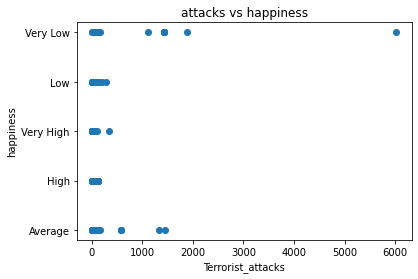

In [ ]:
import matplotlib.pyplot as plt
# Scatter plot
plt.scatter(X_train['Terrorist_attacks'], y_train_labels)

# Labels and title
plt.xlabel('Terrorist_attacks')
plt.ylabel('happiness')
plt.title('attacks vs happiness')

# Show plot
plt.show()